Segmentation is done!
Shapes before limiting:
N: (75011, 200) S: (2779, 200) F: (802, 200) V: (7129, 200) U: (7056, 200)
Shapes after limiting:
N: (800, 200) S: (800, 200) F: (800, 200) V: (800, 200) U: (800, 200)
n_samples: 4000 n_features: 200
n_components: 60
Total explained variance (full precision): 0.9999999996906399
Last cumulative value: 0.99999999969064
----------------------------------------
Total explained variance with 60 components: 1.0000
----------------------------------------


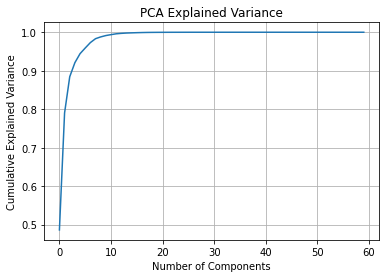

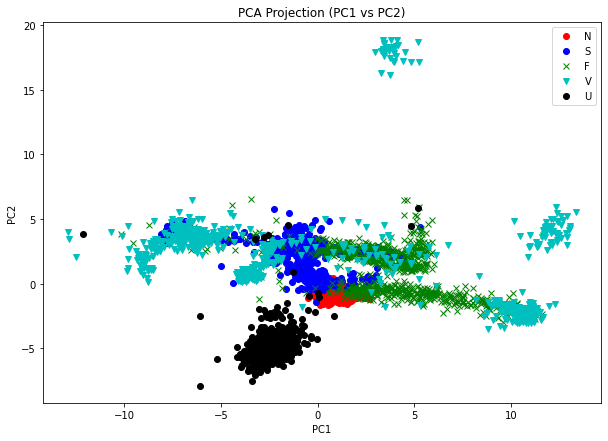

In [8]:
%run ../src/pca_analysis.py